In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU is available.


In [2]:
!pip install matplotlib
!pip install scikit-learn
!pip install -U segmentation-models
!pip install patchify
!pip install Pillow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [4]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"

scaler = MinMaxScaler()
patch_size = 256

In [5]:
#Crop images 256x256x3.
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)

Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_001.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
Now patchifying image: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
Now patchifying imag

In [6]:
 #Now do the same as above for masks
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images

                mask = cv2.imread(path+"/"+mask_name, 1) 
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_001.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_002.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_003.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_004.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_005.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_006.png
Now patchifying mask: /kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/masks/image_part_007.png
Now patchifying mask: /kaggle/inpu

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

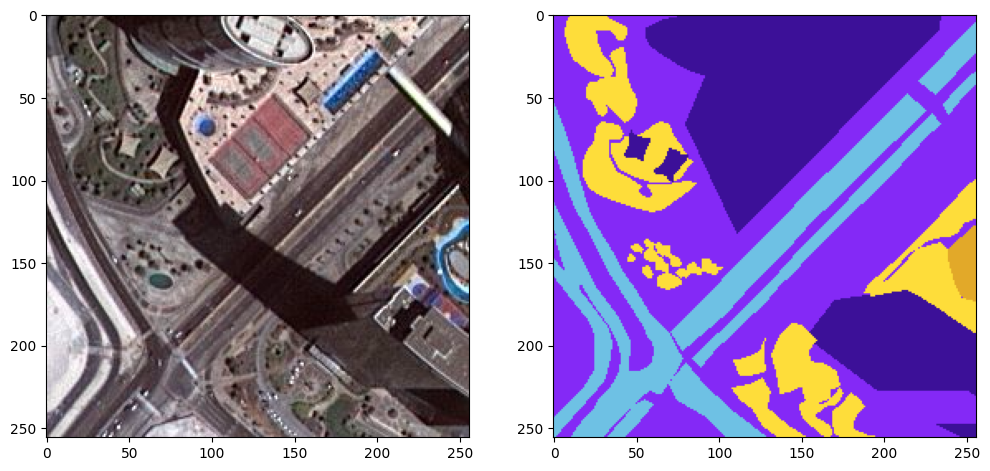

In [8]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [9]:
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41


label = single_patch_mask

60


In [10]:
# Now replace RGB to integer values to be used as labels.

def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    

    label_seg = label_seg[:,:,0] 

    return label_seg

In [11]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    

    label_seg = label_seg[:,:,0] 

    return label_seg
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4]


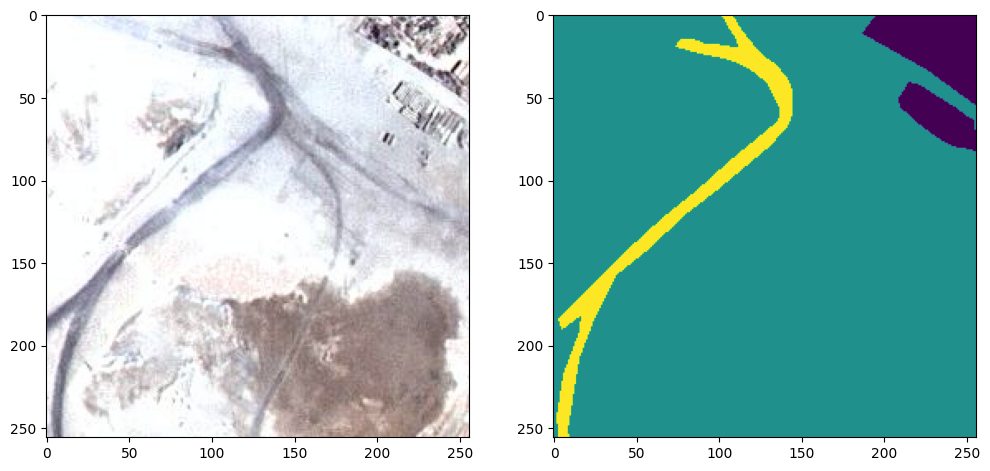

In [12]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [13]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, LayerNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention

# Swin Transformer block
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.mlp = tf.keras.Sequential([
            Dense(self.embed_dim, activation=tf.nn.gelu),
            Dense(self.embed_dim)
        ])
    
    def call(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x, x)
        x = shortcut + x
        x = self.norm2(x)
        x = self.mlp(x)
        return x


def multi_unet_model(n_classes=5, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path (Encoder)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Swin Transformer blocks after key convolutional layers
    swin_block1 = SwinTransformerBlock(num_heads=8, embed_dim=128)
    x1 = swin_block1(p4)

    # Additional Swin Transformer blocks in the bottleneck to capture more complex features
    swin_block2 = SwinTransformerBlock(num_heads=8, embed_dim=128)
    x2 = swin_block2(x1)

    # Expansive path (Decoder) with Multi-scale Fusion and Dilated Convolutions
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x2)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(u6)  # Dilated Conv
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(c6)  # Dilated Conv

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(u7)  # Dilated Conv
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(c7)  # Dilated Conv

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(u8)  # Dilated Conv
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(c8)  # Dilated Conv

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(u9)  # Dilated Conv
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2, 2))(c9)  # Dilated Conv

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Assuming metrics and loss are defined
metrics = ['accuracy']  # Replace 'jacard_coef' with the actual implementation if you have it
total_loss = 'categorical_crossentropy'  # Replacing with dice loss

def get_model():
    return multi_unet_model(n_classes=5, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 2,112,437 (8.06 MB)

 Trainable params: 2,112,437 (8.06 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Set a specific convolution algorithm
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.force_gpu_compatible = True
session = tf.compat.v1.Session(config=config)


In [17]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Set the global policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify the policy
print(f'Mixed precision policy: {tf.keras.mixed_precision.global_policy()}')

Mixed precision policy: <FloatDTypePolicy "mixed_float16">


In [18]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [19]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

# Define a function to save the model at the 150th epoch
def save_150th_epoch(epoch, logs):
    if epoch == 49:  # Remember that epochs are 0-indexed, so 149 is the 150th epoch
        model.save('/kaggle/working/model_at_50_epoch.weights.h5')
        print("Model saved at epoch 50")

# Define the checkpoint callback for the 150th epoch
#save_150_callback = LambdaCallback(on_epoch_end=save_150th_epoch)

# Train the model with the callback
history1 = model.fit(
    X_train, y_train, 
    batch_size=16, 
    verbose=1, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    shuffle=True,
    #callbacks=[save_150_callback]  # Include the custom callback here
)

# Extract the training history
history = history1.history

# Create a DataFrame to store the history
df = pd.DataFrame({
    'epoch': range(1, len(history['loss']) + 1),
    'train_loss': history['loss'],
    'val_loss': history['val_loss'],
    'train_accuracy': history['accuracy'],
    'val_accuracy': history['val_accuracy']
})

# Save the DataFrame to a CSV file
df.to_csv('/kaggle/working/training_history.csv', index=False)

# Display the DataFrame to check
print(df.head())

Epoch 1/100


I0000 00:00:1731422555.086300     129 service.cc:145] XLA service 0x7cac64002d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731422555.086355     129 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731422555.086359     129 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731422572.826911     163 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1731422574.026862     161 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_64', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1731422584.242769     164 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00

65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4262 - loss: 1.3166

I0000 00:00:1731422650.373559     264 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_65', 256 bytes spill stores, 256 bytes spill loads

I0000 00:00:1731422653.585129     261 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_73', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1731422669.203785     264 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00:1731422672.762565     261 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1731422676.811137     263 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1731422679

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4276 - loss: 1.3141   

I0000 00:00:1731422699.213622     129 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_bitcast_reduce_fusion_1', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_bitcast_reduce_fusion', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1731422715.467799     367 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 256 bytes spill stores, 256 bytes spill loads



66/66 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4290 - loss: 1.3117 - val_accuracy: 0.6347 - val_loss: 0.9904
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.6465 - loss: 0.9218 - val_accuracy: 0.6883 - val_loss: 0.8187
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.6929 - loss: 0.8057 - val_accuracy: 0.6821 - val_loss: 0.8692
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.6999 - loss: 0.8020 - val_accuracy: 0.7287 - val_loss: 0.7176
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.7356 - loss: 0.7138 - val_accuracy: 0.7354 - val_loss: 0.7070
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.7537 - loss: 0.6706 - val_accuracy: 0.7334 - val_loss: 0.7319
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.7459 - loss: 0.6910 - val_accuracy: 0.7358 - val_loss: 0.7139
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.7675 - loss: 0.6289 - val_accuracy: 

In [20]:
# Find the epoch with the best validation accuracy
best_epoch = df['val_accuracy'].idxmax() + 1  # idxmax gives index, add 1 for actual epoch number

print(f"Best epoch: {best_epoch}")
print(f"Best validation accuracy: {df['val_accuracy'].max()}")

# Save the model weights at the best epoch with the correct extension
model.save_weights(f'/kaggle/working/best_epoch_{best_epoch}.weights.h5')

Best epoch: 96
Best validation accuracy: 0.8697057962417603


In [21]:
model.save("/kaggle/working/swinUnet_2nd.hdf5")

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

Metrics for Train Set:
  Overall Accuracy: 0.8872
  IoU per class: [0.6355087757820779, 0.8494372169177274, 0.663169628901333, 0.7001619704702259, 0.9414959862906764]
  Mean IoU: 0.7580
  F1 Score: 0.8844
  Precision: 0.8899
  Recall: 0.8872


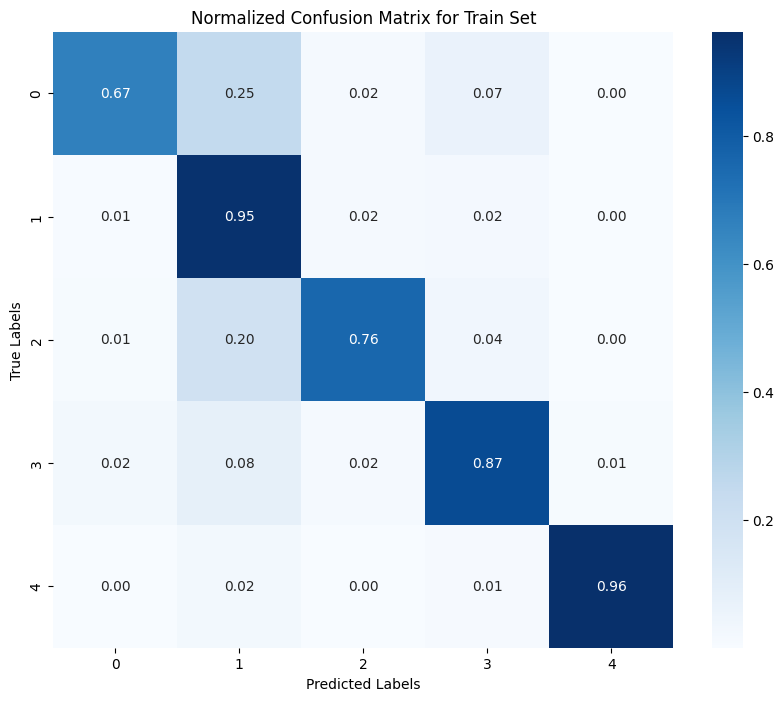

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step

Metrics for Test Set:
  Overall Accuracy: 0.8552
  IoU per class: [0.6069539469629978, 0.8195543946206049, 0.6048085871670398, 0.5814016074714679, 0.8514985010601807]
  Mean IoU: 0.6928
  F1 Score: 0.8523
  Precision: 0.8574
  Recall: 0.8552


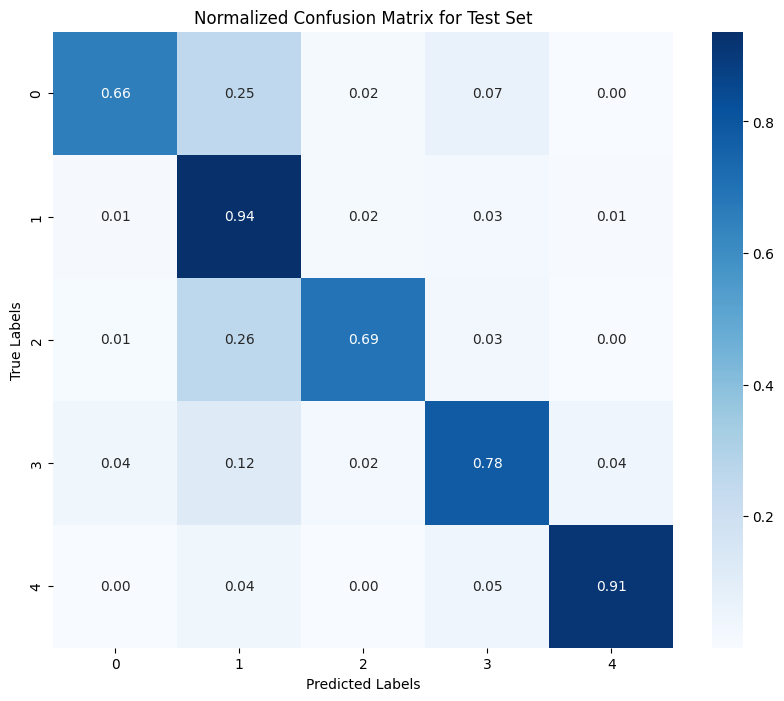


Best validation accuracy (epoch 96): 0.8697


In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best weights based on validation accuracy
saved_model_path = f'/kaggle/working/best_epoch_{best_epoch}.weights.h5'
model.load_weights(saved_model_path)

# Function to calculate metrics
def calculate_metrics(model, X, y, set_name="Dataset"):
    # Predict and reshape predictions and labels
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=-1)
    y_true_labels = np.argmax(y, axis=-1)
    
    # Flatten for metrics calculation
    y_pred_labels_flat = y_pred_labels.flatten()
    y_true_labels_flat = y_true_labels.flatten()

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true_labels_flat, y_pred_labels_flat)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Calculate overall accuracy
    overall_accuracy = np.sum(y_pred_labels_flat == y_true_labels_flat) / len(y_true_labels_flat)

    # IoU for each class
    num_classes = conf_matrix.shape[0]
    iou_per_class = []
    for i in range(num_classes):
        true_positive = conf_matrix[i, i]
        false_positive = np.sum(conf_matrix[:, i]) - true_positive
        false_negative = np.sum(conf_matrix[i, :]) - true_positive
        union = true_positive + false_positive + false_negative
        iou_per_class.append(true_positive / union if union > 0 else 0)

    # Mean IoU
    mean_iou = np.mean(iou_per_class)

    # F1 Score, Precision, Recall
    f1 = f1_score(y_true_labels_flat, y_pred_labels_flat, average='weighted')
    precision = precision_score(y_true_labels_flat, y_pred_labels_flat, average='weighted')
    recall = recall_score(y_true_labels_flat, y_pred_labels_flat, average='weighted')

    # Print metrics
    print(f"\nMetrics for {set_name}:")
    print(f"  Overall Accuracy: {overall_accuracy:.4f}")
    print(f"  IoU per class: {iou_per_class}")
    print(f"  Mean IoU: {mean_iou:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix for {set_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Calculate metrics for each dataset
calculate_metrics(model, X_train, y_train, set_name="Train Set")
calculate_metrics(model, X_test, y_test, set_name="Test Set")

# Display the best validation accuracy found during training
print(f"\nBest validation accuracy (epoch {best_epoch}): {df['val_accuracy'].max():.4f}")


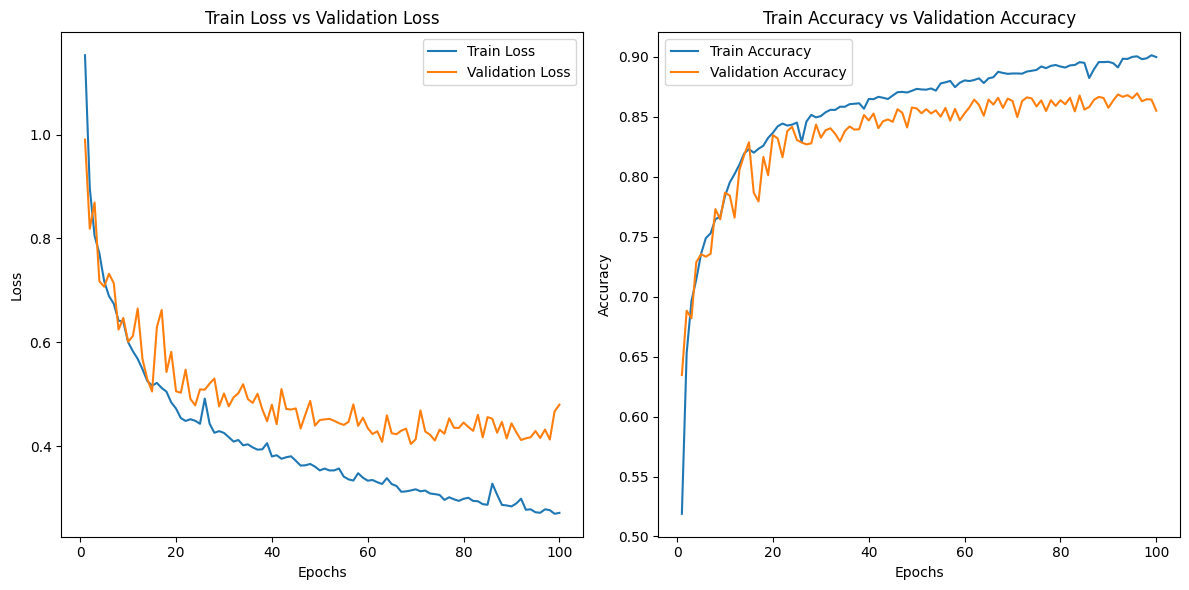

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the CSV file
df = pd.read_csv('/kaggle/working/training_history.csv')

# Plotting Train Loss vs Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Train Accuracy vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_accuracy'], label='Train Accuracy')
plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_pred_labels and y_true_labels are obtained from your model predictions
# y_pred_labels and y_true_labels should be arrays where each element corresponds to a class label for a pixel

# Flatten the arrays to calculate metrics over the entire dataset
y_pred_labels_flat = y_pred_labels.flatten()
y_true_labels_flat = y_true_labels.flatten()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels_flat, y_pred_labels_flat)

# Pixel Accuracy: sum of the diagonal (true positives) over the total number of pixels
pixel_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Mean Pixel Accuracy: average of the diagonal elements (true positives) divided by the total pixels in that class
num_classes = conf_matrix.shape[0]
mean_pixel_accuracy = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))

# Print the results
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

NameError: name 'y_pred_labels' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


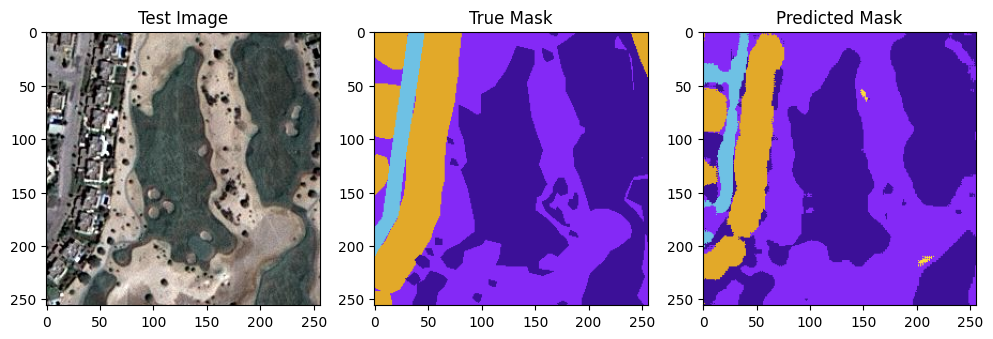

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


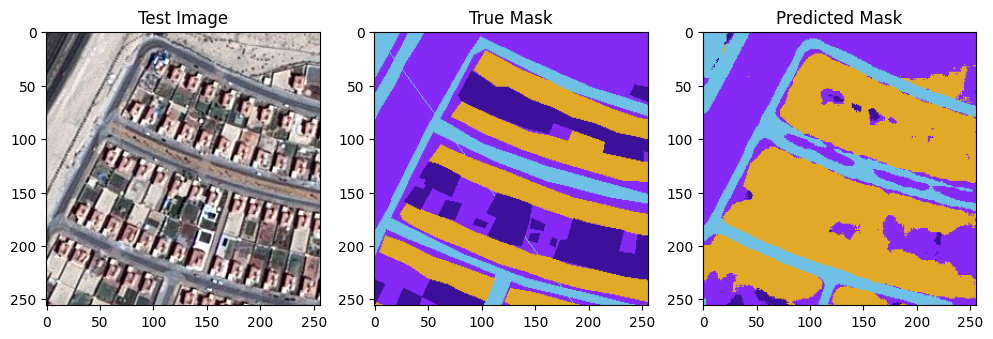

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


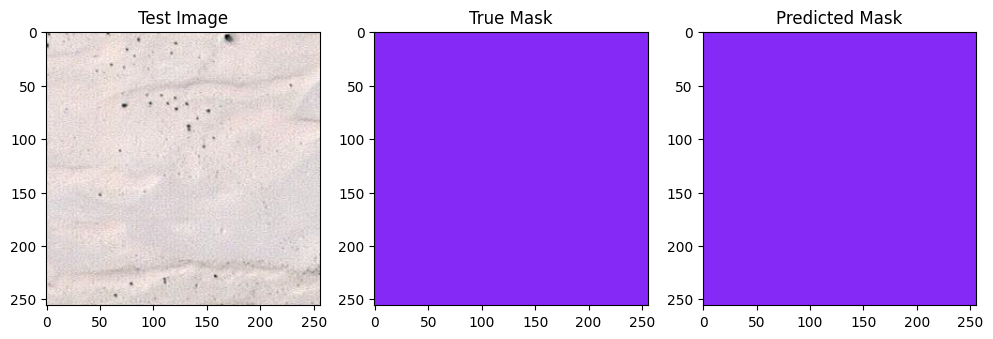

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


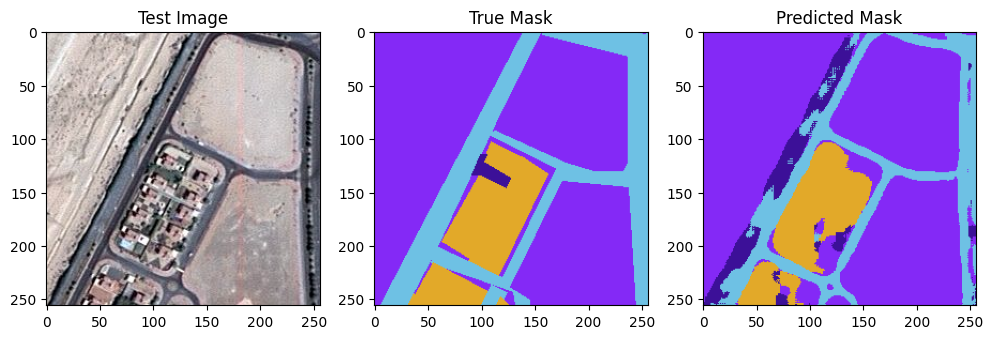

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


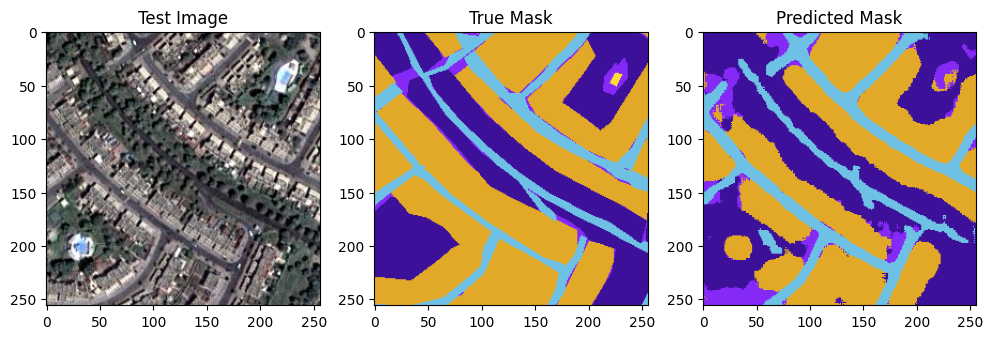

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Updated RGB colors corresponding to each class
colors_rgb = [
    (226, 169, 41),  # Water (#E2A929)
    (132, 41, 246),  # Land (unpaved area) (#8429F6)
    (110, 193, 228), # Road (#6EC1E4)
    (60, 16, 152),   # Building (#3C1098)
    (254, 221, 58),  # Vegetation (#FEDD3A)
    (155, 155, 155)  # Unlabeled (#9B9B9B)
]

def class_to_rgb(mask, colors):
    """Convert class indices to RGB colors using a predefined color map."""
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        rgb_mask[mask == i] = color
    return rgb_mask

# Function to randomly select and predict on a few test images
def random_prediction(model, X_test, y_test, num_images=5):
    # Select random indices from the test set
    indices = random.sample(range(len(X_test)), num_images)   
    for i in indices:
        # Make predictions
        y_pred = model.predict(np.expand_dims(X_test[i], axis=0))
        y_pred_argmax = np.argmax(y_pred, axis=3).squeeze()
        y_true_argmax = np.argmax(y_test[i], axis=2)

        # Convert predictions and true labels to RGB
        y_pred_rgb = class_to_rgb(y_pred_argmax, colors_rgb)
        y_true_rgb = class_to_rgb(y_true_argmax, colors_rgb)

        # Plot the results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title("Test Image")

        plt.subplot(1, 3, 2)
        plt.imshow(y_true_rgb)
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred_rgb)
        plt.title("Predicted Mask")

        plt.show()

# Example: Visualize predictions on 5 random images
random_prediction(model, X_test, y_test, num_images=5)



In [28]:
from tensorflow.keras.layers import LayerNormalization, Dense, MultiHeadAttention

# Define the SwinTransformerBlock (already defined in your code)
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.mlp = tf.keras.Sequential([
            Dense(self.embed_dim, activation=tf.nn.gelu),
            Dense(self.embed_dim)
        ])
    
    def call(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x, x)
        x = shortcut + x
        x = self.norm2(x)
        x = self.mlp(x)
        return x

# Load the model with the custom SwinTransformerBlock layer
saved_model_path = '/kaggle/working/best_epoch_98_full_model.h5'
model = tf.keras.models.load_model(
    saved_model_path,
    custom_objects={"SwinTransformerBlock": SwinTransformerBlock}
)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/best_epoch_98_full_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Using file path for prediction: /path/to/test/image_191.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


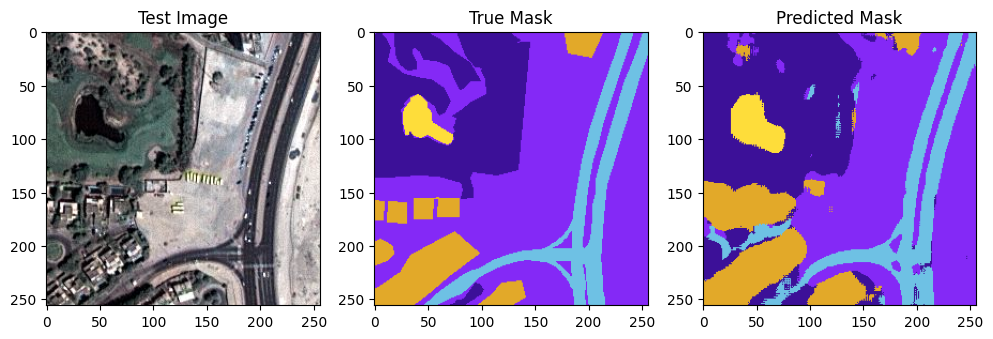

Using file path for prediction: /path/to/test/image_245.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


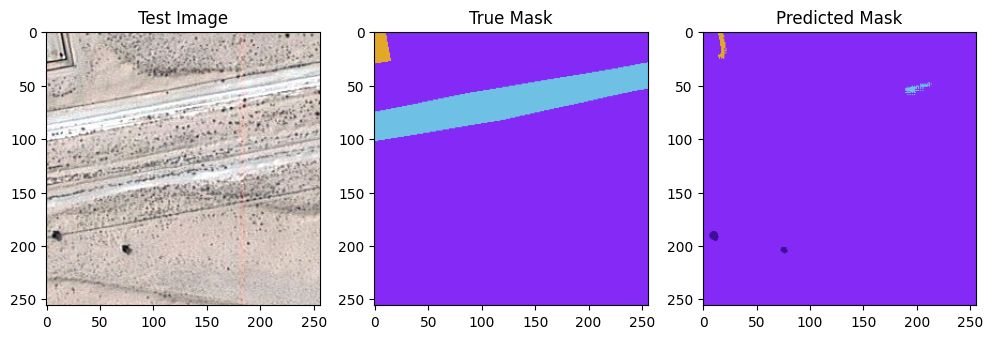

Using file path for prediction: /path/to/test/image_39.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


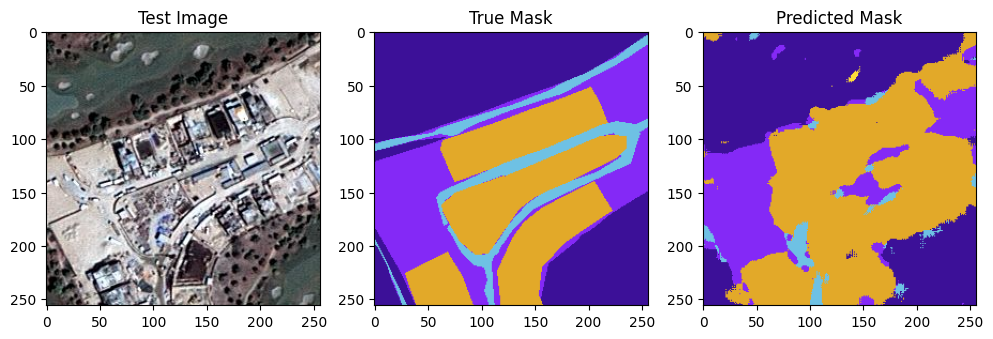

Using file path for prediction: /path/to/test/image_209.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


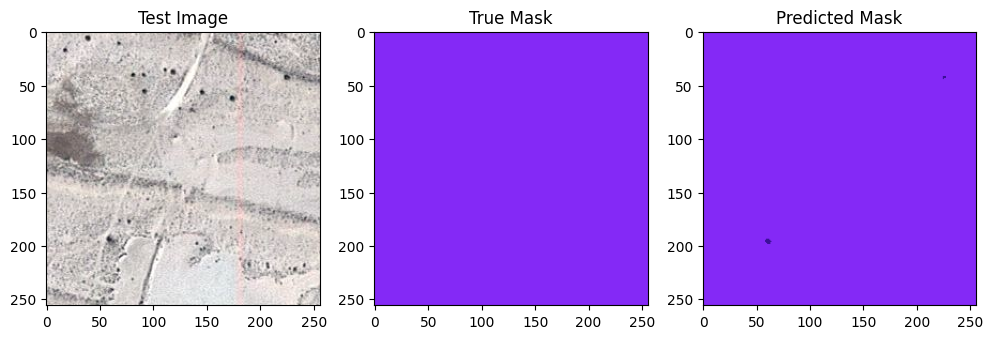

Using file path for prediction: /path/to/test/image_60.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


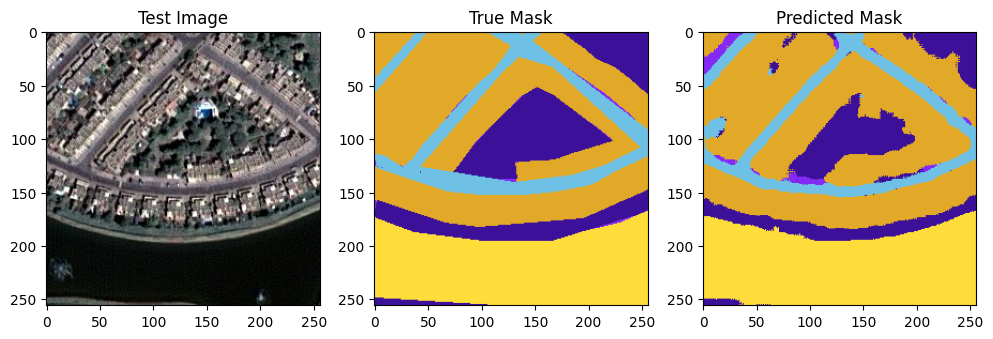

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define the SwinTransformerBlock as you already have
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.mlp = tf.keras.Sequential([
            Dense(self.embed_dim, activation=tf.nn.gelu),
            Dense(self.embed_dim)
        ])
    
    def call(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x, x)
        x = shortcut + x
        x = self.norm2(x)
        x = self.mlp(x)
        return x

# Load the model saved during training, including the custom layer
saved_model_path = '/kaggle/working/best_epoch_98_full_model.h5'
model = load_model(saved_model_path, custom_objects={"SwinTransformerBlock": SwinTransformerBlock})

# Updated RGB colors corresponding to each class
colors_rgb = [
    (226, 169, 41),  # Water (#E2A929)
    (132, 41, 246),  # Land (unpaved area) (#8429F6)
    (110, 193, 228), # Road (#6EC1E4)
    (60, 16, 152),   # Building (#3C1098)
    (254, 221, 58)   # Vegetation (#FEDD3A)
]

def class_to_rgb(mask, colors):
    """Convert class indices to RGB colors using a predefined color map."""
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        rgb_mask[mask == i] = color
    return rgb_mask

# Function to randomly select and predict on a few test images
def random_prediction(model, X_test, y_test, file_paths, num_images=5):
    # Select random indices from the test set
    indices = random.sample(range(len(X_test)), num_images)   
    for i in indices:
        # Print the file path of the selected image
        print(f"Using file path for prediction: {file_paths[i]}")
        
        # Make predictions
        y_pred = model.predict(np.expand_dims(X_test[i], axis=0))
        y_pred_argmax = np.argmax(y_pred, axis=3).squeeze()
        y_true_argmax = np.argmax(y_test[i], axis=2)

        # Convert predictions and true labels to RGB
        y_pred_rgb = class_to_rgb(y_pred_argmax, colors_rgb)
        y_true_rgb = class_to_rgb(y_true_argmax, colors_rgb)

        # Plot the results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title("Test Image")

        plt.subplot(1, 3, 2)
        plt.imshow(y_true_rgb)
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred_rgb)
        plt.title("Predicted Mask")

        plt.show()

# Example file paths list (replace with actual paths to your test images)
file_paths = [f"/path/to/test/image_{i}.jpg" for i in range(len(X_test))]

# Example: Visualize predictions on 5 random images
random_prediction(model, X_test, y_test, file_paths, num_images=5)
